# Ex7: Poisson Image Editing

Poisson Image Editingで画像合成を実験してみましょう．

1. Poisson Image Editingの基本処理部分を実装してください．
2. 自分の画像で合成を実験してください

## 表示用のライブラリのインストール

In [8]:
# プログレスバー用ライブラリのインストール
from fastprogress import progress_bar

## Work: Poisson Image Editingの実装

下記のコードの必要な部分を埋めてPoisson Image Editingを実装してください．

くり返しの更新式は，授業資料も参考にしてください．

### ヒント: くり返し更新式 ($*$はフィルタオペレータ)<br>
$f_n = h_f * f_{n-1} + h_g * g$

$h_f = \left[ \begin{matrix}
    0           & \frac{1}{4} & 0 \\
    \frac{1}{4} & 0           & \frac{1}{4} \\
    0           & \frac{1}{4} & 0 
\end{matrix} \right]$

$h_g = \left[ \begin{matrix}
    0           & -\frac{1}{4} & 0 \\
    -\frac{1}{4} & 1           & -\frac{1}{4} \\
    0           & -\frac{1}{4} & 0 
\end{matrix} \right]$

$ h_f * f_{n-1}$の計算

```py
h_f = np.array([[0, 1/4, 0],
               [1/4, 0, 1/4],
               [0, 1/4, 0]])
h_F_n = cv2.filter2D(F_n, -1, h_f)
```

$ h_g * g$も同様に計算してみましょう．
- $ h_g * g$はfor文の中で更新されるでしょうか？
- $h_f, h_g$の値についてはどうでしょうか？（for文内での更新があるか）

In [9]:
def poisson_image_editing(F_1, G, num_iter):
    # Work: 初期化部分を自由に構成してください．
    # - フィルタカーネルの設定等の準備をしておくと良いです．
    # - 繰り返しと関係ない部分は先に計算しておくと良いです．
    h_g = np.array([[0, -1/4, 0],[-1/4, 1, -1/4],[0, -1/4, 0]])
    h_G = cv2.filter2D(G, -1, h_g)
    # 繰り返し更新する画像の初期化
    F_n = np.array(F_1)

    # 繰り返し処理での画像の更新
    for i in progress_bar(range(num_iter)):
        # Work: F_nの値を基にF_n_newを計算してください．
        h_f = np.array([[0, 1/4, 0],[1/4, 0, 1/4],[0, 1/4, 0]])
        h_F_n = cv2.filter2D(F_n, -1, h_f)

        F_n_new = h_F_n + h_G
        # マスク部分だけ画像を更新する処理
        F_n[G_mask > 0.5] = F_n_new[G_mask > 0.5]
    return F_n


## 補助関数

In [10]:
# 画像の読み込み（BGR⇒RGB，float型への変換）
def loadImage(img_file, target_size):
    I_bgr = cv2.imread(img_file)
    h, w = I_bgr.shape[:2]
    scale = target_size / min(h, w)
    if scale < 1.0:
        I_bgr = cv2.resize(I_bgr, None, fx=scale, fy=scale)
    I = cv2.cvtColor(I_bgr, cv2.COLOR_BGR2RGB)
    I = np.float32(I) / 255.0
    return I

# 結果画像の表示


def show_result(F0, G, F_cloning, F_sc, out_file):
    fig = plt.figure(figsize=(15, 8))
    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05, wspace=0.05)

    plt.subplot(1, 4, 1)
    plt.imshow(F0)
    plt.axis('off')
    plt.title('Background: $f^*$')

    plt.subplot(1, 4, 2)
    plt.imshow(G)
    plt.axis('off')
    plt.title('Foreground: $g$')

    plt.subplot(1, 4, 3)
    plt.imshow(F_cloning)
    plt.axis('off')
    plt.title('Cloning: $f_{cl}$')

    plt.subplot(1, 4, 4)
    plt.imshow(np.clip(F_sc, 0, 1))
    plt.axis('off')
    plt.title('Seamless Cloning: $f_{sc}$')
    fig.savefig(out_file, transparent=True, bbox_inches='tight', pad_inches=0)

# マスクによる画像調整


def fit_mask(G, G_mask, padding=10):
    h, w = G.shape[:2]
    y, x = np.where(G_mask[:, :, 1] > 0.5)
    y_max = min(np.max(y) + padding, h)
    x_max = min(np.max(x) + padding, w)
    y_min = max(np.min(y) - padding, 0)
    x_min = max(np.min(x) - padding, 0)

    return G[y_min:y_max, x_min: x_max, :], G_mask[y_min:y_max, x_min: x_max, :]


## Poisson Image Editingの合成実験

以下のUIを実行して合成結果を確認してください．

In [11]:
#@title 入力ファイルの設定 { run: "auto" }

#@markdown - 実装のテストは配布画像で試すと良いです．
#@markdown - 実装出来たら自分の画像ファイルで実験してください．

#@markdown Work: 背景画像ファイル名を指定してください．

F0_file = "images/yukiyama.png" #@param {type:"string"}

#@markdown Work: 前景画像ファイル名を指定してください．

G_file = "images/uchiyama.png" #@param {type:"string"}

#@markdown Work: 前景マスクファイル名を指定してください．

G_mask_file = "images/uchiyamaKuro.png" #@param {type:"string"}

F0.shape: (900, 1200, 3)
G.shape : (531, 300, 3)


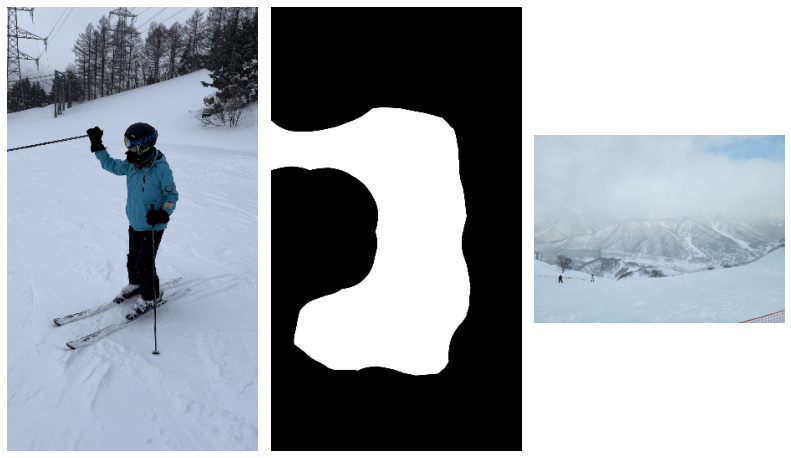

In [12]:
# 必要なライブラリの読み込み
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 画像ファイルの読み込み
F0_target_size = 900
G_target_size = 300

F0 = loadImage(F0_file, F0_target_size)
G_full = loadImage(G_file, G_target_size)
G_mask_full = loadImage(G_mask_file, G_target_size)

fig = plt.figure(figsize=(12,8))
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05, wspace=0.05)

plt.subplot(1, 3, 1)
plt.imshow(G_full)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(G_mask_full)
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(F0)
plt.axis('off')

print("F0.shape: {0}".format(F0.shape))
print("G.shape : {0}".format(G_full.shape))

(-0.5, 1199.5, 899.5, -0.5)

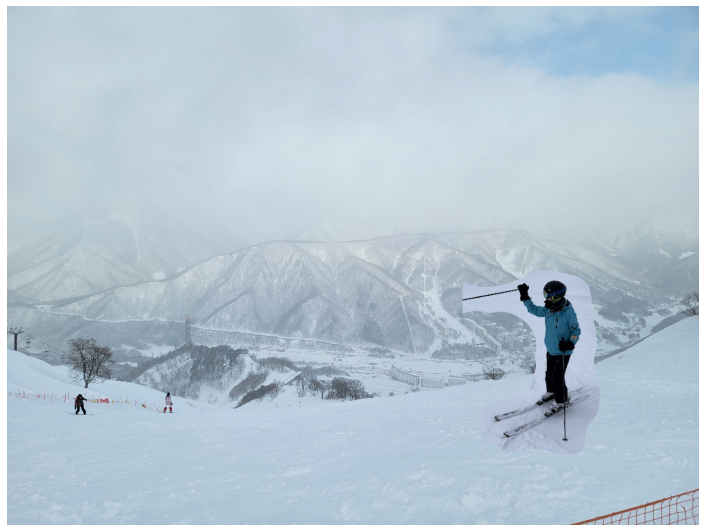

In [13]:
#@title 合成位置の指定 { run: "auto" }

#@markdown 1. 一度コードセルを実行してください．
#@markdown 2. 合成位置・スケーリングをスライダーで調整してください．

#@markdown 合成位置のxを指定してください．

p_x = 0.83 #@param {type:"slider", min:0, max:1.0, step:0.01}

#@markdown 合成位置のyを指定してください．

p_y = 0.8 #@param {type:"slider", min:0, max:1.0, step:0.01}

#@markdown 画像のスケーリングを指定してください．

scale = 1 #@param {type:"slider", min:0.25, max:4.0, step:0.01}

G = cv2.resize(G_full, (0, 0), fx=scale, fy=scale)
h_G, w_G = G.shape[:2]
G_mask = cv2.resize(G_mask_full, (w_G, h_G))

G, G_mask = fit_mask(G, G_mask)
h_G, w_G = G.shape[:2]

p_y = int((F0.shape[0]-h_G)* p_y)
p_x = int((F0.shape[1]-w_G)* p_x)

F_cloning = np.array(F0)
F0_roi = F0[p_y:p_y+h_G, p_x:p_x+w_G, :]
F_cloning_roi = F_cloning[p_y:p_y+h_G, p_x:p_x+w_G, :]
F_cloning_roi = (1.0 - G_mask) * F_cloning_roi + G_mask * G
F_cloning[p_y:p_y+h_G, p_x:p_x+w_G, :] = F_cloning_roi

fig = plt.figure(figsize=(12,8))
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05, wspace=0.05)

plt.imshow(F_cloning)
plt.axis('off')


Text(0.5, 1.0, 'Seamless Cloning: $f_{sc}$')

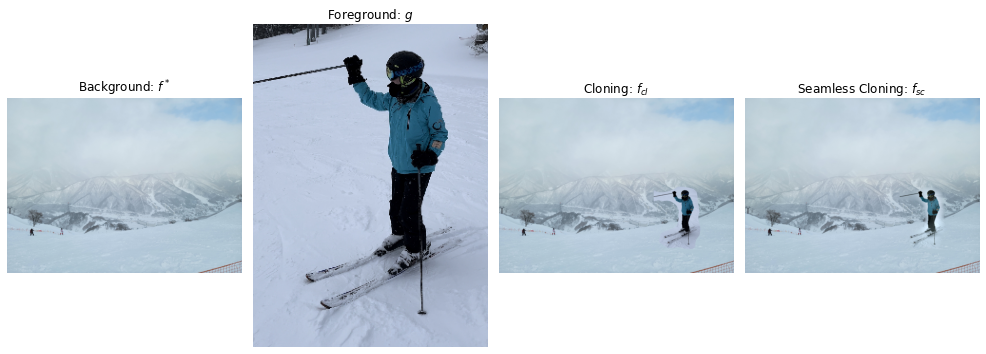

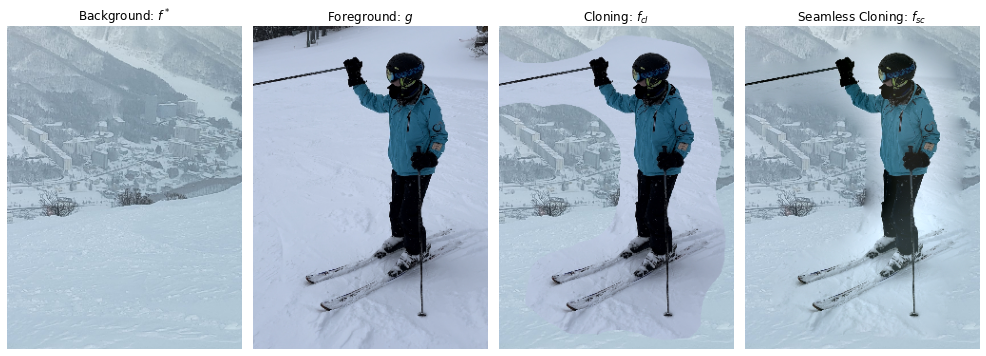

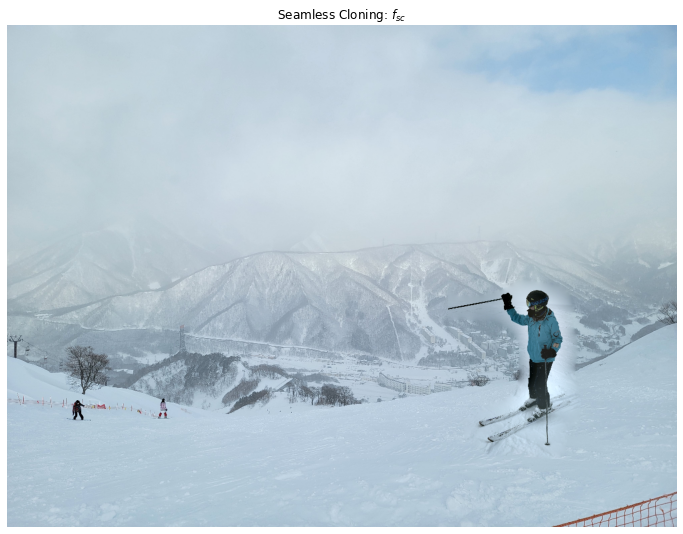

In [14]:
#@title 最適化オプションの指定
#@markdown 繰り返し回数を指定してください．

num_iter = 3000 #@param {type:"slider", min:0, max:5000, step:1}

F_sc = np.array(F0)
F_sc_roi = F_sc[p_y:p_y+h_G, p_x:p_x+w_G, :]

F_sc[p_y:p_y+h_G, p_x:p_x+w_G, :] = poisson_image_editing(F_sc_roi, G, num_iter)

show_result(F0, G, F_cloning, F_sc, "poisson_result.png")
show_result(F0_roi, G, F_cloning_roi, F_sc_roi, "poisson_result_roi.png")

fig = plt.figure(figsize=(12, 12))
plt.imshow(np.clip(F_sc,0,1))
plt.axis('off')
plt.title('Seamless Cloning: $f_{sc}$')